In [7]:
# Import libraries
import pandas as pd
from textblob import TextBlob
from pandas.io.json import json_normalize
from wordcloud import WordCloud
import math
import re
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from nltk.corpus import sentiwordnet as swn
from IPython.display import clear_output
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly
plotly.offline.init_notebook_mode (connected = True)


In [8]:
data = pd.read_csv("filename.csv")
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1515921474464403457,1515576397661556737,2022-04-18 05:13:38 UTC,2022-04-18,05:13:38,0,1243169857857781760,janismelderis74,Jānis Melderis,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'AKorybko', 'name': 'Andrew K...",NaN,NaN,NaN,NaN
1,1515921473097060355,1515920085138898944,2022-04-18 05:13:38 UTC,2022-04-18,05:13:38,0,1462330296314048515,tylermcanally08,Tyler McAnally,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'McFaul', 'name': 'Michael Mc...",NaN,NaN,NaN,NaN
2,1515921471494885382,1512166226814025730,2022-04-18 05:13:37 UTC,2022-04-18,05:13:37,0,1011810506913533953,adamtarver6,Adam Tarver,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'safaren95', 'name': '3B ~ BE...",NaN,NaN,NaN,NaN
3,1515921466402897922,1515921466402897922,2022-04-18 05:13:36 UTC,2022-04-18,05:13:36,0,3421280825,simonishihara,Simon Ishihara,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1515921465216212994,1515921465216212994,2022-04-18 05:13:36 UTC,2022-04-18,05:13:36,0,1187592500,zenjidesign,Izo,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [9]:
# Preprocessing functions
"""
Removing ‘@names’,links (http | https),Punctuations, Numbers and Special characters. Because they don't convey any sentiment of the text

"""

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Basic function to clean the text
def clean_tweet(text):
    text = str(text)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove identifications
    text = re.sub(r'@\w+', '', text)
    # Remove links
    text = re.sub(r'http.?://[^/s]+[/s]?', '', text)
    return text.strip().lower()


def analyze_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [10]:
data['Sentiment'] = data['tweet'].apply(lambda x:analyze_sentiment(x))
data['Source'] = 'random_user'
data['Length'] = data['tweet'].apply(len)
data['Word_counts'] = data['tweet'].apply(lambda x:len(str(x).split()))

data=data[['tweet','retweets_count', 'Sentiment', 'Source', 'Length','Word_counts']]
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts
0,@AKorybko @McFaul @M_Simonyan Did you forget t...,0,1,random_user,231,37
1,"@McFaul No doubt, Russia’s operation in Ukrain...",0,1,random_user,67,10
2,@safaren95 i came here because i saw you troll...,0,1,random_user,228,43
3,Mariupol under relentless attack from Russia ...,0,0,random_user,207,23
4,"@mei_m298748 In Cyprus, Russian connections ar...",0,-1,random_user,275,45


In [11]:
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
data['Clean tweet'] = data['tweet'].apply(lambda x:clean_tweet(x))
data.head()

,tweet,retweets_count,Sentiment,Source,Length,Word_counts,Clean tweet
0,@AKorybko @McFaul @M_Simonyan Did you forget t...,0,1,random_user,231,37,did you forget to take your medicine? russia ...
1,"@McFaul No doubt, Russia’s operation in Ukrain...",0,1,random_user,67,10,"no doubt, russia’s operation in ukraine has be..."
2,@safaren95 i came here because i saw you troll...,0,1,random_user,228,43,i came here because i saw you trolling for rus...
3,Mariupol under relentless attack from Russia ...,0,0,random_user,207,23,mariupol under relentless attack from russia ...
4,"@mei_m298748 In Cyprus, Russian connections ar...",0,-1,random_user,275,45,"in cyprus, russian connections are everywhere...."


In [7]:
neutral = data[data['Sentiment'] == 0]
positive = data[data['Sentiment'] == 1]
negative = data[data['Sentiment'] == -1]

In [8]:
x = ['Neutral', 'Positive', 'Negative']
y = [len(neutral),  len(positive), len(negative)]

import plotly.graph_objs as go
# Use the hovertext kw argument for hover text
fig = go.Figure(data=[go.Bar(x=x, y=y,
            hovertext=['61% of tweets', '28% of tweets', '11% of tweets'])])

# Customize aspect
#marker_color='rgb(158,202,225)'
fig.update_traces(marker_line_color='midnightblue',
                  marker_line_width=1.)
fig.update_layout(title_text='Distribution of sentiment')
fig.show()

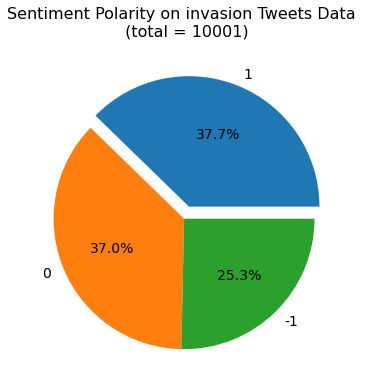

In [9]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in data['Sentiment'].value_counts()]
labels = list(data['Sentiment'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on invasion Tweets Data \n (total = {})'.format(len(data)), fontsize = 16, pad = 20)
plt.show()

In [10]:
#neutral_text
print("Neutral tweet example  :",neutral['tweet'].values[15])
# Positive tweet
print("Positive Tweet example :",positive['tweet'].values[37])
#negative_text
print("Negative Tweet example :",negative['tweet'].values[1])

Neutral tweet example  : Will Vladimir Putin deliver on Russia’s carbon emission pledges?
Positive Tweet example : Latest Russia-Ukraine war news: Live updates  https://t.co/1IHibT4soH
Negative Tweet example : @Noahpinion Russia wins wars thru attrition. Their leaders don't care about their soldiers so they send endless waves of them until any enemy is exhausted of men, firepower and will to fight.


In [11]:
x = data.Length.values


fig = go.Figure(data=[go.Histogram(x=x,
                                   marker_line_width=1,
                                   marker_line_color="midnightblue",
                                   xbins_size = 5)])

fig.update_layout(title_text='Distribution of tweet lengths')
fig.show()

In [12]:
x1 = neutral.Length.values
x2 = positive.Length.values
x3 = negative.Length.values

fig = go.Figure(data=[go.Histogram(x=x1,
                                   marker_line_width=1,
                                   marker_line_color="midnightblue",
                                   xbins_size = 5,
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of neutral tweet lengths')
fig.show()

fig = go.Figure(data=[go.Histogram(x=x2,
                                   marker_line_width=1,
                                   marker_color='rgb(50,202,50)',
                                   marker_line_color="midnightblue",
                                   xbins_size = 5,
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of positive tweet lengths')
fig.show()

fig = go.Figure(data=[go.Histogram(x=x3,
                                   marker_line_width=1,
                                   marker_color='crimson',
                                   marker_line_color="midnightblue",
                                   opacity = 0.5)])

fig.update_layout(title_text='Distribution of negative tweet lengths')
fig.show()

In [13]:
y1 = neutral.Length.values
y2 = positive.Length.values
y3 = negative.Length.values

fig = go.Figure()

fig.add_trace(go.Box(y=y1,
                     name="Neutral",
                     marker_line_width=1,
                     marker_line_color="midnightblue"))

fig.add_trace(go.Box(y=y2,
                     name="Positive",
                     marker_line_width=1,
                     marker_color = 'rgb(50,202,50)'))

fig.add_trace(go.Box(y=y3,
                     name="Negative",
                     marker_line_width=1,
                     marker_color = 'crimson'))

fig.update_layout(title_text="Box Plot tweet lengths")

fig.show()

In [14]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for i in text_list:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

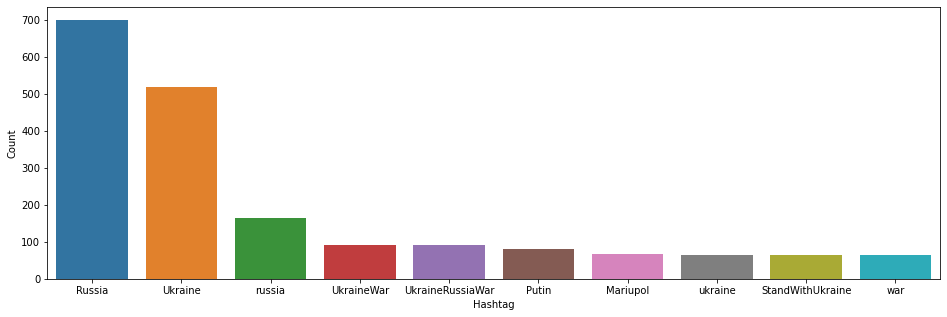

In [15]:
hashtags  = hashtag_extract(data['tweet'])
hashtags  = sum(hashtags ,[])

a = nltk.FreqDist(hashtags )
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

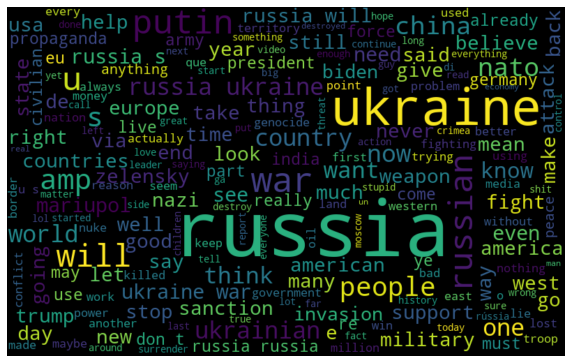

In [16]:
all_words = ' '.join([text for text in data['Clean tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

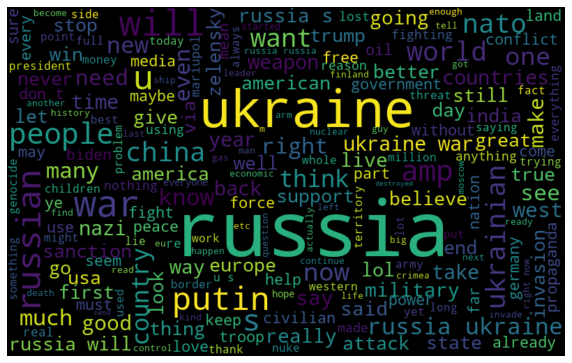

In [17]:
positive_words =' '.join([text for text in data['Clean tweet'][data['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

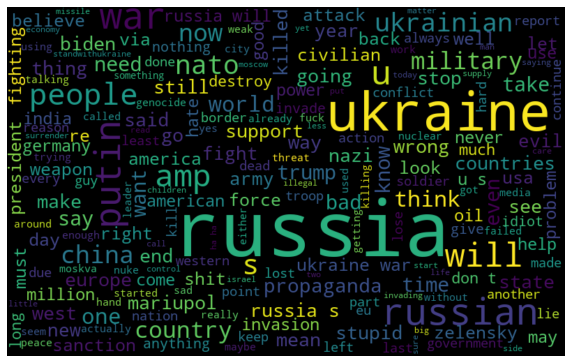

In [18]:
negative_words =' '.join([text for text in data['Clean tweet'][data['Sentiment'] == -1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()